In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt

os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon\alpiq-datathon-2025-main\datasets2025')

data = pd.read_csv('training_set_IT.csv', index_col=0, parse_dates=True)

assert data.isna().sum().sum() == 0

print('Shape:', data.shape)
print('Cols:', data.columns)

Shape: (22632, 3399)
Cols: Index(['VALUEMWHMETERINGDATA_customerIT_1',
       'VALUEMWHMETERINGDATA_customerIT_2',
       'VALUEMWHMETERINGDATA_customerIT_3',
       'VALUEMWHMETERINGDATA_customerIT_4',
       'VALUEMWHMETERINGDATA_customerIT_5',
       'VALUEMWHMETERINGDATA_customerIT_6',
       'VALUEMWHMETERINGDATA_customerIT_7',
       'VALUEMWHMETERINGDATA_customerIT_8',
       'VALUEMWHMETERINGDATA_customerIT_13',
       'VALUEMWHMETERINGDATA_customerIT_14',
       ...
       'INITIALROLLOUTVALUE_customerIT_2850',
       'INITIALROLLOUTVALUE_customerIT_2851',
       'INITIALROLLOUTVALUE_customerIT_2852', 'is_holiday', 'spv', 'temp',
       'temperature_2m', 'relative_humidity_2m', 'cloudcover',
       'precipitation'],
      dtype='object', length=3399)


In [33]:
y_cols = [col[:20] == 'VALUEMWHMETERINGDATA' for col in data.columns]

X = data.iloc[:-1,:].copy()
Y = data.loc[:,y_cols].shift(-1).iloc[:-1,:].copy()

assert X.isna().sum().sum() == 0 and Y.isna().sum().sum() == 0

In [ ]:
### Add Categorical Vars

X.index = pd.to_datetime(X.index)

month = X.index.month
weekday = X.index.weekday
hour = X.index.hour

X.loc[:,'month_sin'] = np.sin(2 * np.pi * month / 12)
X.loc[:,'month_cos'] = np.cos(2 * np.pi * month / 12)
X.loc[:,'day_sin'] = np.sin(2 * np.pi * weekday / 7)
X.loc[:,'day_cos'] = np.cos(2 * np.pi * weekday / 7)
X.loc[:,'hour_sin'] = np.sin(2 * np.pi * hour / 24)
X.loc[:,'hour_cos'] = np.cos(2 * np.pi * hour / 24)

cols_cat = [
    'month_sin','month_cos',
    'day_sin','day_cos',
    'hour_sin','hour_cos'
            ]

In [35]:
# Set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def plot_loss(train_losses, val_losses):
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 3 columns
    # First plot: Loss evolution (val loss alone)
    axes[0].set_title('Loss evolution (val loss alone)')
    axes[0].plot(train_losses, label='validation', marker='o')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[1].set_title('Loss evolution (val loss alone)')
    axes[1].plot(val_losses, label='validation', marker='o')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

In [36]:
os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon')

from models import xLSTMModel, TransformerDecoderOnly

Epoch 1/500, Train Loss: 0.1212, Val Loss: 0.1090
Epoch 2/500, Train Loss: 0.0942, Val Loss: 0.1004
Epoch 3/500, Train Loss: 0.0868, Val Loss: 0.0976
Epoch 4/500, Train Loss: 0.0806, Val Loss: 0.0957
Epoch 5/500, Train Loss: 0.0760, Val Loss: 0.0941
Epoch 6/500, Train Loss: 0.0729, Val Loss: 0.0913
Epoch 7/500, Train Loss: 0.0713, Val Loss: 0.0906
Epoch 8/500, Train Loss: 0.0704, Val Loss: 0.0897
Epoch 9/500, Train Loss: 0.0698, Val Loss: 0.0890
Epoch 10/500, Train Loss: 0.0693, Val Loss: 0.0872
Epoch 11/500, Train Loss: 0.0687, Val Loss: 0.0874
Epoch 12/500, Train Loss: 0.0682, Val Loss: 0.0878
Epoch 13/500, Train Loss: 0.0679, Val Loss: 0.0860
Epoch 14/500, Train Loss: 0.0675, Val Loss: 0.0881
Epoch 15/500, Train Loss: 0.0672, Val Loss: 0.0862
Epoch 16/500, Train Loss: 0.0669, Val Loss: 0.0877
Epoch 17/500, Train Loss: 0.0667, Val Loss: 0.0869
Epoch 18/500, Train Loss: 0.0666, Val Loss: 0.0876
Epoch 19/500, Train Loss: 0.0663, Val Loss: 0.0873
Epoch 20/500, Train Loss: 0.0662, Val Lo

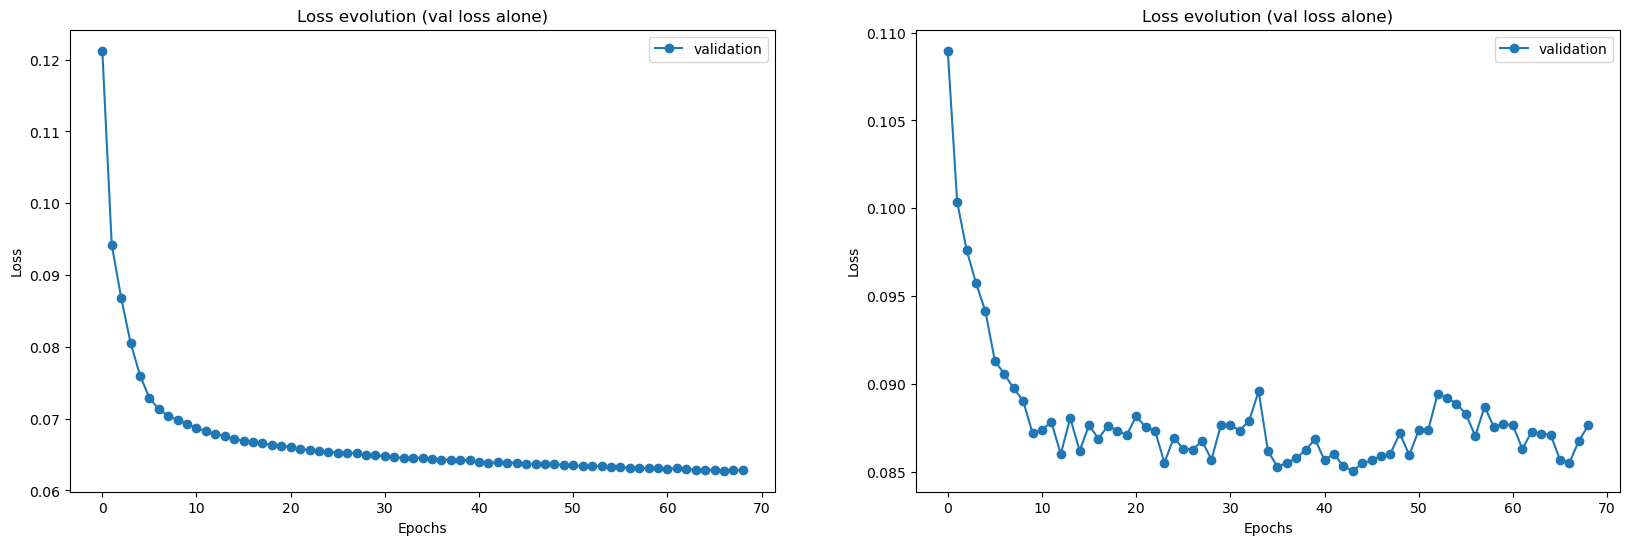

In [37]:
seed = 1  # You can choose any integer value
set_seed(seed)

# Split the data into training (first 80%) and validation (last 20%)
split_idx = int(0.9 * len(X))  # Calculate the split index

# Standardize the data
scaler_X = StandardScaler()
scaler_Y = MinMaxScaler()

# Fit the scalers on the training data and transform both training and validation data
X_train = scaler_X.fit_transform(X.drop(cols_cat, axis=1).iloc[:split_idx])
X_val = scaler_X.transform(X.drop(cols_cat, axis=1).iloc[split_idx:])
Y_train = scaler_Y.fit_transform(Y.iloc[:split_idx])
Y_val = scaler_Y.transform(Y.iloc[split_idx:])

X_train_cat = X[cols_cat].iloc[:split_idx]
X_val_cat = X[cols_cat].iloc[split_idx:]

X_train = np.concatenate([X_train, X_train_cat], axis=1)
X_val = np.concatenate([X_val, X_val_cat], axis=1)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader for batching
batch_size = 200

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_dim = X_train.shape[1]  # Number of features (e.g., energy consumption + naive forecasts)
hidden_dim = 168  # Increased hidden dimension for better capacity # (24,168)
output_dim = Y_train.shape[1]  # Number of firms (or target variables)
num_layers = 3  # Deeper LSTM
dropout = 0.3  # Dropout to prevent overfitting
max_grad_norm = 5.0  # Maximum gradient norm for clipping

# dropout = 0.5: BAD
# batch_size = 300: BAD

# Initialize the model, loss function, and optimizer
model = xLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Early stopping parameters
num_epochs = 500
best_val_loss = float('inf')
patience = 25
epochs_no_improve = 0
best_model_path = "best_lstm_model.pth"

train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
        loss = criterion(outputs, Y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded.")
plot_loss(train_losses, val_losses)

In [38]:
model_save_IT = model

In [43]:
# Load test data
os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon\alpiq-datathon-2025-main\datasets2025')
test_ = pd.read_csv('forecast_set_IT_weather.csv', index_col=0, parse_dates=True)

# Merge historical data with test data
test = pd.concat([data, test_], axis=0)

# Ensure the index is sorted (important for time series)
test = test.sort_index()

# Add cyclical features to test data
month = test.index.month
weekday = test.index.weekday
hour = test.index.hour

test['month_sin'] = np.sin(2 * np.pi * month / 12)
test['month_cos'] = np.cos(2 * np.pi * month / 12)
test['day_sin'] = np.sin(2 * np.pi * weekday / 7)
test['day_cos'] = np.cos(2 * np.pi * weekday / 7)
test['hour_sin'] = np.sin(2 * np.pi * hour / 24)
test['hour_cos'] = np.cos(2 * np.pi * hour / 24)

# Initialize an empty DataFrame to store predictions
predictions = pd.DataFrame(index=test_.index, columns=Y.columns)

# Define sequence length (e.g., 168 for weekly patterns)
seq_length = 168

# Loop through each row in test_
for i, timestamp in enumerate(test_.index):

    # Define the input sequence for the model
    start_idx = test.index.get_loc(timestamp) - seq_length
    end_idx = test.index.get_loc(timestamp)
    input_sequence = test.iloc[start_idx:end_idx]

    # Standardize the input sequence (use the scaler fitted on training data)
    input_sequence_scaled = scaler_X.transform(
        input_sequence.drop(cols_cat, axis=1)
        )
    input_sequence_scaled = np.concatenate(
        [input_sequence_scaled, input_sequence[cols_cat]], axis=1
        )

    # Convert to PyTorch tensor and add batch and sequence dimensions
    input_tensor = torch.tensor(input_sequence_scaled, dtype=torch.float32).unsqueeze(0)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        predicted_values = model(input_tensor).squeeze(0).numpy()

    # Inverse transform the predictions to the original scale
    predicted_values_original = scaler_Y.inverse_transform(predicted_values.reshape(1, -1))[0]

    # Store the predictions
    predictions.loc[timestamp] = predicted_values_original

    # Update the test DataFrame with the predicted values
    test.loc[timestamp, Y.columns] = predicted_values_original

# The `predictions` DataFrame now contains the forecasted values for `test_`

In [44]:
test = test.loc[test_.index[0]:,:]
test.to_csv('predictions_IT.csv', index=True)

# APPENDIX

In [ ]:
X.index = pd.to_datetime(X.index)
# holiday_ES.index = pd.to_datetime(holiday_ES.index)

# temp = X.index.strftime('%Y-%m-%d').isin(holiday_ES.index.strftime('%Y-%m-%d'))

# X['holiday'] = [int(val) for val in temp]
month = X.index.month
weekday = X.index.weekday
hour = X.index.hour

X.loc[:,'month_sin'] = np.sin(2 * np.pi * month / 12)
X.loc[:,'month_cos'] = np.cos(2 * np.pi * month / 12)
X.loc[:,'day_sin'] = np.sin(2 * np.pi * weekday / 7)
X.loc[:,'day_cos'] = np.cos(2 * np.pi * weekday / 7)
X.loc[:,'hour_sin'] = np.sin(2 * np.pi * hour / 24)
X.loc[:,'hour_cos'] = np.cos(2 * np.pi * hour / 24)

cols_cat = [
    'month_sin','month_cos',
    'day_sin','day_cos',
    'hour_sin','hour_cos'
            ]

In [30]:
seed = 1  # You can choose any integer value
set_seed(seed)

# Standardize the data
scaler_X = StandardScaler()
scaler_Y = MinMaxScaler()

# Fit the scalers on the training data and transform both training and validation data
X_train = scaler_X.fit_transform(X.drop(cols_cat, axis=1))
Y_train = scaler_Y.fit_transform(Y)

X_train_cat = X[cols_cat]
X_val_cat = X[cols_cat]

X_train = np.concatenate([X_train, X_train_cat], axis=1)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

# Create DataLoader for batching
batch_size = 200

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model parameters
input_dim = X_train.shape[1]  # Number of features (e.g., energy consumption + naive forecasts)
hidden_dim = 168  # Increased hidden dimension for better capacity # (24,168)
output_dim = Y_train.shape[1]  # Number of firms (or target variables)
num_layers = 3  # Deeper LSTM
dropout = 0.3  # Dropout to prevent overfitting
max_grad_norm = 5.0  # Maximum gradient norm for clipping

# dropout = 0.5: BAD
# batch_size = 300: BAD

# Initialize the model, loss function, and optimizer
model = xLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
num_epochs = 500
best_val_loss = float('inf')
patience = 500
epochs_no_improve = 0
best_model_path = "best_lstm_model.pth"

train_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
        loss = criterion(outputs, Y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# Load the best model
print("Best model loaded.")
plot_loss(train_losses, val_losses)

Epoch 1/500, Train Loss: 0.1418
Epoch 2/500, Train Loss: 0.1098
Epoch 3/500, Train Loss: 0.0954
Epoch 4/500, Train Loss: 0.0896
Epoch 5/500, Train Loss: 0.0865
Epoch 6/500, Train Loss: 0.0842
Epoch 7/500, Train Loss: 0.0813
Epoch 8/500, Train Loss: 0.0778
Epoch 9/500, Train Loss: 0.0757
Epoch 10/500, Train Loss: 0.0740
Epoch 11/500, Train Loss: 0.0726
Epoch 12/500, Train Loss: 0.0715
Epoch 13/500, Train Loss: 0.0702


KeyboardInterrupt: 

In [ ]:
# Load test data
os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon\alpiq-datathon-2025-main\datasets2025')
test_ = pd.read_csv('forecast_set_IT_weather.csv', index_col=0, parse_dates=True)

# Merge historical data with test data
test = pd.concat([data, test_], axis=0)

# Ensure the index is sorted (important for time series)
test = test.sort_index()

# Add cyclical features to test data
month = test.index.month
weekday = test.index.weekday
hour = test.index.hour

test['month_sin'] = np.sin(2 * np.pi * month / 12)
test['month_cos'] = np.cos(2 * np.pi * month / 12)
test['day_sin'] = np.sin(2 * np.pi * weekday / 7)
test['day_cos'] = np.cos(2 * np.pi * weekday / 7)
test['hour_sin'] = np.sin(2 * np.pi * hour / 24)
test['hour_cos'] = np.cos(2 * np.pi * hour / 24)

# Initialize an empty DataFrame to store predictions
predictions = pd.DataFrame(index=test_.index, columns=Y.columns)

# Define sequence length (e.g., 168 for weekly patterns)
seq_length = 168

# Loop through each row in test_
for i, timestamp in enumerate(test_.index):

    # Define the input sequence for the model
    start_idx = test.index.get_loc(timestamp) - seq_length
    end_idx = test.index.get_loc(timestamp)
    input_sequence = test.iloc[start_idx:end_idx]

    # Standardize the input sequence (use the scaler fitted on training data)
    input_sequence_scaled = scaler_X.transform(
        input_sequence.drop(cols_cat, axis=1)
        )
    input_sequence_scaled = np.concatenate(
        [input_sequence_scaled, input_sequence[cols_cat]], axis=1
        )

    # Convert to PyTorch tensor and add batch and sequence dimensions
    input_tensor = torch.tensor(input_sequence_scaled, dtype=torch.float32).unsqueeze(0)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        predicted_values = model(input_tensor).squeeze(0).numpy()

    # Inverse transform the predictions to the original scale
    predicted_values_original = scaler_Y.inverse_transform(predicted_values.reshape(1, -1))[0]

    print(predicted_values_original)

    # Store the predictions
    predictions.loc[timestamp] = predicted_values_original

    # Update the test DataFrame with the predicted values
    test.loc[timestamp, Y.columns] = predicted_values_original

# The `predictions` DataFrame now contains the forecasted values for `test_`

In [161]:
test = test.loc[test_.index[0]:,:]
test.to_csv('predictions_IT.csv', index=True)